<a href="https://colab.research.google.com/github/lapshinaaa/homework_DeepLearning/blob/main/hw3_iad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-07 17:52:36--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-07 17:52:36--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.1s    

2023-12-07 17:52:36 (114 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

**To understand how to complete this task I used the following resource:** https://www.kaggle.com/code/gokifujiya/face-mask-object-detection-with-xml-file

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # finding xmin, ymin, xmax, ymax
        xmin = int(member.find("bndbox").find("xmin").text)
        ymin = int(member.find("bndbox").find("ymin").text)
        xmax = int(member.find("bndbox").find("xmax").text)
        ymax = int(member.find("bndbox").find("ymax").text)

        # finding the class label for the object
        class_label = class_dict[member.find("name").text]  # using class_dict to get the numeric ID

        # compiling the collected information as a dict
        res = {
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax,
            "class": class_label
        }

        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # function for returning images with corresponding detection boxes
        fname = self.filenames[idx]
        image = Image.open(fname).convert("RGB") # opening the image
        image = np.array(image)
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        # extracting bounding box coordinates and labels
        bboxes = [
            (bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"], bbox["class"])
            for bbox in bboxes
        ]

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        # applying permute and reverse normalization
        image = images[i].permute(1, 2, 0).numpy() * std + mean
        image = np.clip(image, 0, 1)  # this is to avoid matplotlib warnings

        ax.imshow(image)


        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class_id = bbox

            class_label = train_ds.class_dict_inv[class_id] # getting the string value

            # drawing bounding box
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )

            ax.add_patch(rect)
            ax.text(
                xmin,
                ymin,
                f"{class_label}",
                fontsize=6,
                bbox=dict(facecolor="red", alpha=0.5, edgecolor="black", boxstyle="round,pad=0.1"),
                color="white",
            )

    fig.tight_layout()
    plt.show()

**A quick note about 'permute' here: ** the permute(1, 2, 0) operation is  swapping the dimensions to rearrange them from the PyTorch default order to the order expected by Matplotlib, which is (H, W, C).

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

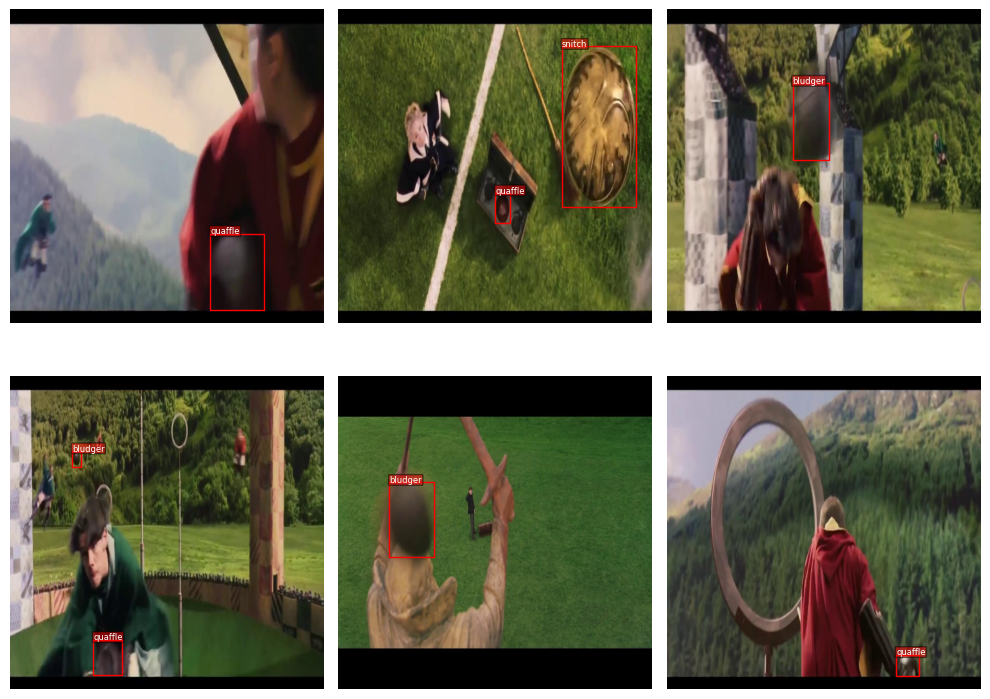

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO

Сейчас нам предстоить реализовать YOLO детектор. Это один из самых простых детекторов с точки зрения реализации. Он описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Мы будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16. В каждом пикселе мы будем предсказывать размеры прямоугольника и класс.



We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and width to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности. В каналах у нас будут записаны координаты центра, центр относительно координат пикселя, бинарная переменная (детекция присутствует), класс детекции.

**This material was used for understanding the process of finding the center of a bounding box: ** https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection

**This material on github was used for understanding the normalization process of width and height of a bounding box: ** https://github.com/ultralytics/yolov3/issues/475?ysclid=lpgsyfsr1c918990068

In [9]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = xmax - xmin
        y_cell = ymax - ymin

        # dividng by width and height
        w_box =  x_cell / w
        h_box =  y_cell / h

        cx = (xmax + xmin) / 2
        cy = (ymax + ymin) / 2

        cx_idx =  (cx // downsample).long()
        cy_idx =  (cy // downsample).long()

        # calculating the offsets
        cx_box =  cx % downsample / downsample
        cy_box =  cy % downsample / downsample

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

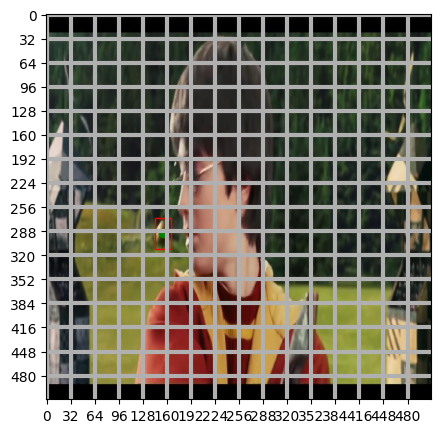

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Реализуйте аналогичные принципы, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами.

То есть, нужно проделать операции из collate_fn в обратную сторону.

**Found some more relevant and important information here as well: **https://giters.com/apple/coremltools/issues/1339?ysclid=lpmkjfduhg682978453

In [11]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    decoded_predictions = []

    # iterating over batchs
    for i in range(b):
      decoded_bboxes = []

      # iterating over each pixel of the decoded prediction
      for y in range(h):
          for x in range(w):
              pred_yx = pred[i, :, y, x] # taking a prediction for this particular cell

              if pred_yx[4] > threshold:
                  # performing reverse normalization
                  cx_cell, cy_cell = pred_yx[0], pred_yx[1]

                  cx = (cx_cell + x) * upsample
                  cy = (cy_cell + y) * upsample

                  bbox_height, bbox_width = pred_yx[2] * img_h, pred_yx[3] * img_w

                  # calculating the coordinates
                  xmin = cx - (bbox_width / 2)
                  xmax = cx + (bbox_width / 2)
                  ymin = cy - (bbox_height / 2)
                  ymax = cy + (bbox_height / 2)

                  class_pred = pred_yx[5:].numpy()
                  decoded_bboxes.append((xmin, ymin, xmax, ymax, np.argmax([class_pred])))

      decoded_predictions.append(decoded_bboxes)


    return decoded_predictions

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 вклюяительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [12]:
# calculating the number of unique classes in the entire dataset
dataset = PascalDataset(root="./data/", transform=train_transform)
num_classes = len(set(dataset.class_dict.values()))

print("Number of classes:", num_classes)

Number of classes: 3


In [13]:
import torchvision.models as models
C =  3

class Detector(nn.Module):
    def __init__(self, C):
        super(Detector, self).__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # taking the first 4 blocks
        self.resnet_blocks = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )

        # adding extra layers according to the task
        self.layers_addition = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        )

    def forward(self, img):
      # forward pass
        x = self.resnet_blocks(img)
        x = self.layers_addition(x)
        x = F.interpolate(x, size=(16, 16), mode='bilinear', align_corners=False)
        x = torch.sigmoid(x)

        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)

* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [14]:
from torch.nn import MSELoss, CrossEntropyLoss, BCELoss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def class_loss(pred, target, num_classes):
    # creating a mask to select elements where target > 0
    masking = (target > 0).unsqueeze(1).expand_as(pred)

    spred = torch.masked_select(pred, masking)
    starget = target[target > 0]
    spred = spred.view(-1, num_classes)

    # calculating cross-entropy loss
    classification_loss = F.cross_entropy(spred, starget.long(), reduction='sum')

    return classification_loss

In [16]:
def special_loss(pred, target, check=False, C=C):
    # 1: LOCALIZATION LOSS
    # creating a mask
    loc_mask = target[:, :2, :, :] > 0
    # applying the mask
    masked_target = torch.masked_select(target[:, :2, :, :], loc_mask)
    masked_pred = torch.masked_select(pred[:, :2, :, :], loc_mask)
    # calculating loss
    loss = MSELoss(reduction='sum')
    localization_loss = loss(masked_target, masked_pred)


    # 2: BOX LOSS
    # creating a mask
    box_mask = target[:, 2:4, :, :] > 0
    # applying the mask
    masked_target_box = torch.masked_select(target[:, 2:4, :, :], box_mask)
    masked_pred_box = torch.masked_select(pred[:, 2:4, :, :], box_mask)
    # calculating loss
    loss = MSELoss(reduction='sum')
    box_loss = loss(torch.sqrt(masked_target_box), torch.sqrt(masked_pred_box))


    # 3: CLASSIFICATION LOSS

    # extracting class scores (for prediction) and labels (for target)
    class_pred = pred[:, 5:, :, :]
    class_target = target[:, 5, :, :]

    classification_loss = class_loss(class_pred, class_target, C)


    # 4: BINARY CROSS-ENTROPY

    confidence_losses = []  # initialize list to store confidence losses
    detection_mask = target[:, 4, :, :] > 0
    # iterating through each pixel and calculate confidence loss
    for i in range(pred.size(2)):  # the height of the prediction
        for j in range(pred.size(3)):  #  the width of the prediction
            if detection_mask[:, i, j].any(): # all pictures from the batch, their height and width
                # detected objects:  weight 1.0
                weight = torch.tensor(1.0)
            else:
                # undetected objects:  weight 0.1
                weight = torch.tensor(0.1)

            loss = BCELoss(
                weight=weight,
                reduction='sum'
            )
            confidence_losses.append(loss(
                pred[:, 4, i, j],
                target[:, 4, i, j]
            ))

    # stacking confidence losses
    confidence_loss = torch.stack(confidence_losses).sum()

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss
    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [17]:
print(special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3))

(tensor(5120.), tensor(5120.), tensor(2812.4465), tensor(256000.))


In [18]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [57]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 20
model = Detector(C).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        images, targets = batch['image'], batch['target']
        images, targets = images.to(device), targets.to(device)

        # forward pass
        predictions = model(images)
      #  target_decoded= decode_prediction(targets.cpu())
       # decoded = decode_prediction(predictions.cpu(), threshold=0.5)
     #   print(decoded)
      #  print(target_decoded)
       # if len(decoded) > 0:
      #  visualize([images[0].cpu()], [target_decoded[0]])

        # calculating loss
        loss = special_loss(predictions.cpu(), targets.cpu())

        # backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 116.536;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 33.083;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 18.348;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 14.099;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 12.063;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 10.119;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 9.308;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 9.432;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 11.718;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 12.679;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 10.191;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 8.733;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 7.574;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 6.076;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 5.554;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 5.482;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 5.271;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 5.110;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 5.015;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 5.053;


Запустим обученный детектор на тестовых изображениях:

In [59]:
test_loader = torch.utils.data.DataLoader(test_ds, 30, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [60]:
# Нужно сделать предсказание и переложить результат на cpu

# setting to evaluation mode
model.eval()

# getting a batch for making a prediction
images, _ = batch['image'].to(device), batch['target'].to(device)

# making predictions and storing them on cpu
with torch.no_grad():
    predictions = model(images)

predictions = predictions.cpu()

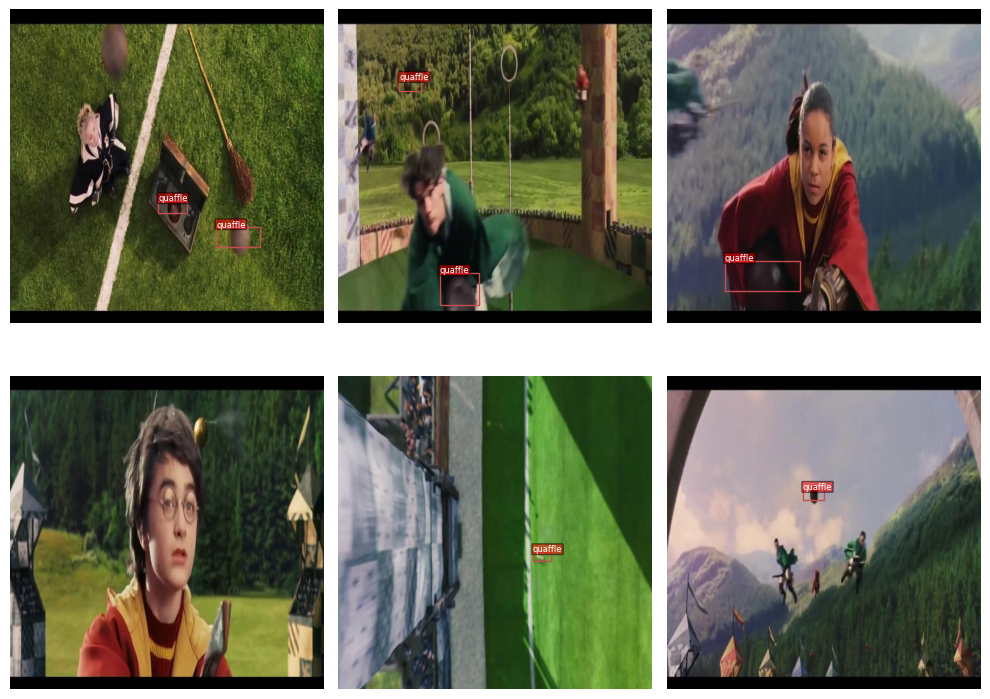

In [62]:
decoded_predictions = decode_prediction(predictions, threshold=0.5)

visualize([images[i].cpu() for i in range(16,22)], [decoded_predictions[i] for i in range(16,22)])

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [21]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.4/659.4 kB 5.8 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [22]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [36]:
def annotation2txt(bboxes, w_im, h_im):
    # storing annotations in a list
    text_annotations = []

    # iterating over all bboxes
    for bbox in bboxes:
        class_label = bbox['class']
        x_min = bbox['xmin']
        y_min = bbox['ymin']
        x_max = bbox['xmax']
        y_max = bbox['ymax']

        x_center = (x_min + x_max) / 2.0
        y_center = (y_min + y_max) / 2.0

        width = x_max - x_min
        height = y_max - y_min

        x_center /= w_im
        y_center /= h_im

        width /= w_im
        height /= h_im

        # appending annotations
        text_annotations.append(f"{class_label} {x_center} {y_center} {width} {height}")

    return text_annotations

In [37]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [40]:
# Собираем YAML

nc =  len(train_ds.class_dict)
names = train_ds.class_dict_inv

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

In [41]:
print(names)

{0: 'snitch', 1: 'quaffle', 2: 'bludger'}


## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [43]:
import ultralytics

path = 'yolov8n.yaml'
model = ultralytics.YOLO(path)

# training the model
results = model.train(data='data.yaml', epochs=20, pretrained=False)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 59.5MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.88G       4.56      9.203      4.236         30        640: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.76G      4.969      8.709      4.133         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.71G       4.19      7.751      3.934         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.71G      3.721      6.643      3.614         38        640: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.7G      3.512      6.173      3.291         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.7G      3.142      6.129      2.999         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.7G       3.06      5.808       2.88         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.7G      2.897       5.06      2.659         39        640: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.7G      2.705      4.869      2.583         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.7G      2.781      4.635      2.414         34        640: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         29         35          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.71G      2.569      5.376       2.43         15        640: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.71G      2.455      5.343      2.389         17        640: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.7G      2.542      5.151      2.425         12        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.71G      2.363      4.935      2.261         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.71G      2.388      4.644      2.259         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.7G      2.387      4.681       2.31         13        640: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.7G      2.308      4.383      2.107         16        640: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.7G       2.24       4.25      2.086         13        640: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.71G      2.251      4.231      2.119         13        640: 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.71G      2.254      4.194      2.096         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         29         35          0          0          0          0



20 epochs completed in 0.042 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         29         35          0          0          0          0


Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train4


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [65]:
import os

vp = "/content/valid/images"
lp = list(map(lambda x: f"{vp}/{x}", os.listdir(path=vp))) # список с путями к файлам
lst = []
for i in lp:
    img = np.array(Image.open(i).convert("RGB"))
    res = model.predict(img)
    if res[0].boxes.data.shape != torch.Size([0, 6]):
        lst.append(res)

TypeError: ignored